In [35]:
import numpy as np
from scipy.optimize import minimize
import nlopt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.style.use(r"C:\Users\B30724\Documents\Python\presentation.mplstyle")

As an example, we'll look at the following simple nonlinearly constrained minimization problem:
$$
\min_{\mathbf{x}\:\in\:\mathbb{R}^2} \: 1-\text{e}^{-\left[(x_1-1)^2 + (x_1-1)(x_2-1) + \frac{1}{2}(x_2-1)^2 \right]}
$$
with bound constraints: $0 \leq x_1 \leq 1$ and $0 \leq x_2 \leq 1$. The minimum is 0, achieved at $\mathbf{x}=[1,1]$.

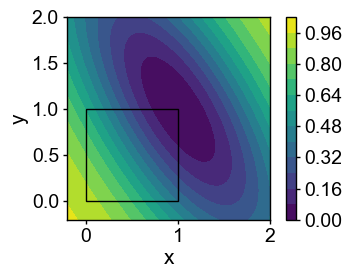

In [36]:
x = np.linspace(-0.2,2,101)
y = np.linspace(-0.2,2,101)
xx, yy = np.meshgrid(x, y)
f = lambda X, Y: 1 - np.exp(-((X-1)**2 + (X-1)*(Y-1) + 0.5*(Y-1)**2))

fig, ax = plt.subplots(figsize=(4,3))
ax.set(xlabel='x', ylabel='y')
img = ax.contourf(xx, yy, f(xx, yy), levels=12)
ax.add_patch(Rectangle((0,0), 1, 1, lw=1, ec='k', fc='none'))
ax.set_aspect('equal')
fig.colorbar(img, ax=ax)
fig.tight_layout()

The objective (and constraint) function takes NumPy arrays as arguments. If the `grad` argument is non-empty, it must be modified in-place to the value of the gradient. We could define the objective/constraints as classes with a `__call__(self, x, grad)` method so that they can behave like functions

__Important__: Modifying `grad` in-place

The `grad` argument of your objective/constraint functions must be modified in-place. If you use an operation like 
`grad = 2*x`
Python allocates a new array to hold `2*x` and reassigns grad to point to it, rather than modifying the original contents of grad. This will not work. Instead, you should do:
`grad[:] = 2*x`

In [37]:
def myfunc(x, grad):
    exp = np.exp(-((x[0]-1)**2 + (x[0]-1)*(x[1]-1) + 0.5*(x[1]-1)**2))
    val = 1 - exp
    if grad.size > 0:
        grad[0] = (2*(x[0]-1) + x[1]-1) * exp
        grad[1] = (x[0]-1 + x[1]-1) * exp
    return val

opt = nlopt.opt(nlopt.LD_MMA, 2)
# opt = nlopt.opt(nlopt.LD_LBFGS, 2)
# opt = nlopt.opt(nlopt.LD_SLSQP, 2)
# opt = nlopt.opt(nlopt.LD_TNEWTON, 2)
opt.set_lower_bounds([0, 0])
opt.set_upper_bounds([1.2, 1.2])
opt.set_min_objective(myfunc)
opt.set_xtol_rel(1e-6)
x = opt.optimize([0.1, 0.1])  # Returns only the location of the optimum
minf = opt.last_optimum_value()  # Value of the optimum
print("Optimum at", x[0], x[1])
print("Minimum value = ", minf)
print("Result code = ", opt.last_optimize_result())

Optimum at 1.0000000359488146 0.9999998951270183
Minimum value =  2.9976021664879227e-15
Result code =  4


Implement a class to store intermediate results.

In [75]:
class FuncGrad:
    def __init__(self):
        self.hist_x = []
        self.hist_f = []
        self.hist_g = []
    def __call__(self, x, grad):
        self.hist_x.append(np.copy(x))  # Important to copy!
        exp = np.exp(-((x[0]-1)**2 + (x[0]-1)*(x[1]-1) + 0.5*(x[1]-1)**2))
        val = 1 - exp
        self.hist_f.append(val)
        if grad.size > 0:  # Modify grad in place!
            grad[0] = (2*(x[0]-1) + x[1]-1) * exp
            grad[1] = (x[0]-1 + x[1]-1) * exp
            self.hist_g.append(np.copy(grad))  # Important to copy!
        return val  # Must return function value
    
myfunc = FuncGrad()
upper = 1.4
opt = nlopt.opt(nlopt.LD_MMA, 2)
# opt = nlopt.opt(nlopt.LD_LBFGS, 2)
# opt = nlopt.opt(nlopt.LD_SLSQP, 2)
# opt = nlopt.opt(nlopt.LD_TNEWTON, 2)
opt.set_lower_bounds([0, 0])
opt.set_upper_bounds([upper, upper])
opt.set_min_objective(myfunc)
opt.set_xtol_rel(1e-6)
x0 = np.array([0.1, 0.1])
x = opt.optimize(x0)  # Returns only the location of the optimum
minf = opt.last_optimum_value()  # Value of the optimum
print("Optimum at", x[0], x[1])
print("Minimum value = ", minf)
print("Result code = ", opt.last_optimize_result())

Optimum at 1.0000009855381307 0.9999986343791267
Minimum value =  5.578870698741412e-13
Result code =  4


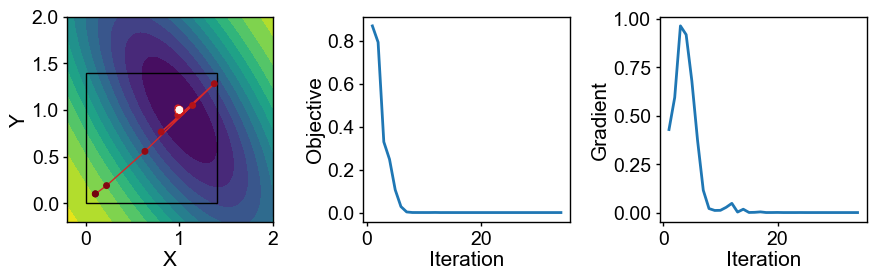

In [76]:
def plot_history(x0, x_hist, f_hist, g_hist, upper=1.0):

    traj = np.vstack([x0] + x_hist)
    color = plt.cm.Reds(np.linspace(1,0,len(traj)))
    x = np.linspace(-0.2,2,101)
    y = np.linspace(-0.2,2,101)
    xx, yy = np.meshgrid(x, y)
    f = lambda X, Y: 1 - np.exp(-((X-1)**2 + (X-1)*(Y-1) + 0.5*(Y-1)**2))

    fig, axs = plt.subplots(1,3, figsize=(9,3))
    axs[0].contourf(xx, yy, f(xx, yy), levels=12)
    axs[0].plot(traj[:,0], traj[:,1], c='C3', lw=1, zorder=1)
    axs[0].scatter(traj[:,0], traj[:,1], marker='.', c=color, zorder=2)
    axs[0].add_patch(Rectangle((0,0), upper, upper, lw=1, ec='k', fc='none'))
    axs[0].set(xlabel="X", ylabel="Y")
    axs[0].set(xlim=[-0.2,2], ylim=[-0.2,2])
    axs[0].set_aspect('equal')
    axs[1].plot(range(1,len(f_hist)+1), f_hist)
    axs[1].set(xlabel="Iteration", ylabel="Objective")
    axs[2].plot(range(1,len(g_hist)+1), [np.linalg.norm(g, ord=2) for g in g_hist])
    axs[2].set(xlabel="Iteration", ylabel="Gradient")
    fig.tight_layout()

plot_history(x0, myfunc.hist_x, myfunc.hist_f, myfunc.hist_g, upper=upper)